## Université de Montréal

# IFT3395-6390-A-A17 - Fondements de l'apprentissage machine

## Travail pratique 2,3

réalisé par


<p>Amina Madzhun  matricule 20052277</p>
<p>Georgiy Gegiya matricule 1005468</p>

## 1. Calcul des gradients

Dans un premier temps, on va caluler le gradient pour un seul un exemple, et vérifiez que le calcul est correct avec la technique de vérification du gradient par différence finie.

Tout d'abord, nous allons implementer des fonctions utilitaires pour calculer les fonctions d'activations et leur dérivés: 

In [2]:
import numpy as np
from matplotlib import pyplot as plt


def safe_softmax(v):
    exps = np.exp(v - np.max(v))
    return exps / np.sum(exps)


def safe_softmax_matrix(m):
    return np.array([safe_softmax(v) for v in m])


def random_uniform(min_val, max_val):
    return np.random.uniform(min_val, max_val, 1)[0]


def relu(x):
    return np.maximum(x, 0)


def onehot_matrix(m, y):
    targets = np.array([y]).reshape(-1)
    return np.eye(m)[targets]


def one_hot(m, y):
    return np.array(map(lambda x: 1 if x == y else 0, range(m)))


def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x



La méthode qui fait la propagation “avant” c.a.d. le calcul étape par étape depuis l’entrée, jusqu’à la sortie et au coût, des activations de chaque couche.

In [3]:
def fprop(self, x):
    """
    walk forward from input layer x to output layer
    """
    # apply W1 weights + B1 bias
    # vector ha: dim = dh
    self._ha = np.dot(x, self.w1.transpose()) + self.b1

    # apply non-linear activation function RELU
    # vector hs: dim = dh
    self._hs = relu(self._ha)

    # apply W2 weights + B2 bias
    # vector oa: dim = m
    oa = np.dot(self._hs, self.w2.transpose()) + self.b2

    # apply softmax function
    # out dimension: m (# number of output neurones)
    self._out = safe_softmax(oa)

La méthode bprop se sert des activations calculées par le précédent appel à fprop et
effectue la rétropropagation du gradient depuis le coût jusqu'à l’entrée
en suivant précisément les étapes dérivées dans la partie 1.

Par la suite, en utilisant ce méthodes, on va créer une classe qui représente un réseau neurones avec une couche de neurones cachées:

In [61]:
class MLPerceptronIterative(object):
    def __init__(self, nb_hidden=6, mu=0.01, epochs=100, batch_size=50,
                 l11=0.005, l12=0.001, l21=0.005, l22=0.001, grad_threshold=0.5, validate_gradient=False):
        self.nb_hidden = nb_hidden
        self.mu = mu
        self.epochs = epochs
        self.grad_threshold = grad_threshold
        self.nb_out = 0
        self.nb_features = 0
        self.nb_samples = 0
        self.epsilon = 1e-5  # default gradient verification step
        self.train_data = None  # features from training data
        self.w2 = None
        self.w1 = None
        self.b1 = None
        self.b2 = None
        self._ha = None  # hidden layer activations
        self._hs = None  # hidden layer outputs
        self._out = None  # network output layer outputs
        self._validate_gradient = validate_gradient
        self.batch_size = batch_size
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22

    def description(self):
        return "{0} : hidden={1}, learn.rate={2}, epochs={3}, batch={4}\n" \
               r"$\lambda11={5}, \lambda12={6}, \lambda21={7}, \lambda22={8}$".format(
            self.__class__.__name__,
            self.nb_hidden,
            self.mu,
            self.epochs,
            self.batch_size,
            self.l11,
            self.l12,
            self.l21,
            self.l22)

    def init_weights(self, i, j):
        """
        Initialize the weight matrix i x j for the layer of n entries
        :param i: number of rows of the matrix W
        :param j: number of columns
        :return: two-dimensional numpy array
        """
        max_val = 1 / np.sqrt(j)
        return np.matrix([[random_uniform(-max_val, max_val) for _ in range(j)] for _ in range(i)])

    def init_bias(self, i):
        return np.zeros(i)

    def train(self, train_data):
        # initialize the weight matrices and bias arrays
        self.train_data = train_data
        self.nb_samples = np.shape(self.train_data)[0]
        classes = train_data[:, -1].astype(int)  # convert labels to integers
        self.nb_features = np.shape(train_data)[1] - 1  # exclude the last column which contains the labels
        self.nb_out = np.max(classes) + 1  # number neurons in the output layer == number of the classes
        self.w2 = self.init_weights(self.nb_out, self.nb_hidden)  # dimension m X dh
        self.w1 = self.init_weights(self.nb_hidden, self.nb_features)  # dimensions dh x X
        self.b2 = self.init_bias(self.nb_out)  # dimensions m
        self.b1 = self.init_bias(self.nb_hidden)  # dimension dh
        # train
        for epoch in range(self.epochs):
            # split the data into mini-batches and train the network for the each batch
            np.random.shuffle(self.train_data)
            for i in range(0, self.nb_samples, self.batch_size):
                batch = self.train_data[i:i + self.batch_size]
                self.train_batch(batch)
        print("\nCalculated coefficients:")
        print("\nW1: %s" % self.w1)
        print("\nb1: %s" % self.b1)
        print("\nW2: %s" % self.w2)
        print("\nb2: %s" % self.b2)

    def train_batch(self, batch):
        batch_size = len(batch)
        batch_gradient_w1 = np.zeros((self.nb_hidden, self.nb_features))
        batch_gradient_w2 = np.zeros((self.nb_out, self.nb_hidden))
        batch_gradient_b1 = np.zeros(self.nb_hidden)
        batch_gradient_b2 = np.zeros(self.nb_out)
        for example in batch:
            x = example[:-1]  # array, dim = d, # of features, or input neurones
            y = int(example[-1])  # scalar
            self.fprop(x)
            # Gradient check for each parameter
            grad_w1, grad_b1, grad_w2, grad_b2 = self.bprop(x, y)

            # accumulate gradients
            batch_gradient_w1 += grad_w1
            batch_gradient_b1 += grad_b1
            batch_gradient_w2 += grad_w2
            batch_gradient_b2 += grad_b2

        grad_w1 = (batch_gradient_w1 +
                   np.multiply(np.sign(self.w1), self.l11) +
                   np.multiply(self.w1, (self.l12 * 2))) / batch_size

        grad_b1 = batch_gradient_b1 / batch_size

        grad_w2 = (batch_gradient_w2 +
                   np.multiply(np.sign(self.w2), self.l21) +
                   np.multiply(self.w2, (self.l22 * 2))) / batch_size

        grad_b2 = batch_gradient_b2 / batch_size

        batch_x = batch[:, :-1]
        batch_y = batch[:, -1].astype(int)

        if self._validate_gradient:
            self.validate_gradient(batch_x, batch_y, grad_w1, grad_b1, grad_w2, grad_b2)

        self.update_parameters(grad_w1, grad_b1, grad_w2, grad_b2)

    def validate_gradient(self, x, y, grad_w1, grad_b1, grad_w2, grad_b2):
        """
        Validate if the gradient calculated by backpropagation algorithm is similar
        to the empirical gradient calculated with finite step epsilon
        :param x: array of features, dim = K x d
        :param y: array of labels, dim = K
        :raises: exception if the calculated algorithm is too different from empirical
        """
        # calculate finite gradient
        model_parameters = ['w1', 'b1', 'w2', 'b2']
        backprop_gradient = [grad_w1, grad_b1, grad_w2, grad_b2]
        for pidx, pname in enumerate(model_parameters):
            # Get the actual parameter value by it's name, e.g. w1, w2 etc
            parameter = self.__getattribute__(pname)
            # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index
                # Save the original value so we can reset it later
                original_value = parameter[ix]
                # Estimate the gradient using (f(x+h) - f(x-h))/2h
                # calculate the empirical error for x+h
                parameter[ix] = original_value + self.epsilon
                self.fprop(x)
                grad_plus = self.empirical_error(y)
                # calculate the empirical error for x-h
                parameter[ix] = original_value - self.epsilon
                self.fprop(x)
                grad_minus = self.empirical_error(y)
                # Reset parameter to original value
                parameter[ix] = original_value

                # verify gradient
                estimated_gradient = (grad_plus - grad_minus) / (2 * self.epsilon)
                calculated_gradient = backprop_gradient[pidx][ix]
                diff = np.abs(calculated_gradient - estimated_gradient)
                summ = np.abs(calculated_gradient) + np.abs(estimated_gradient)
                grad_error = 0
                if summ != 0:
                    grad_error = diff / summ
                print("\ngradient %s%s: estimated: %s, calculated: %s, diff: %s" % (
                pname, ix, estimated_gradient, calculated_gradient, grad_error))
                if grad_error > self.grad_threshold:
                    raise Exception("\nGradient diff is too big: ", grad_error)
                it.iternext()

    def empirical_error(self, y):
        """
        Compute regularized empirical error
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot_matrix(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        err = np.mean(log_err)
        regularized_err = err + \
                          self.l11 * abs(self.w1).sum() + \
                          self.l21 * abs(self.w2).sum() + \
                          self.l12 * np.power(self.w1, 2).sum() + \
                          self.l22 * np.power(self.w2, 2).sum()
        return regularized_err

    def fprop(self, x):
        """
        :param x: numpy array of the features, dim = d
        walk forward from input layer x to output layer
        """
        # apply W1 weights + B1 bias
        # ha : array(dh_
        self._ha = np.dot(x, self.w1.transpose()) + self.b1

        # apply non-linear activation function RELU
        # hs : array(dh)
        self._hs = relu(self._ha)

        # apply W2 weights + B2 bias
        # oa : array(m)
        oa = np.dot(self._hs, self.w2.transpose()) + self.b2

        # apply softmax function
        # out : array(m) m = # number of output neurones
        self._out = safe_softmax(oa)

    def bprop(self, x, y):
        """
        Calculate gradients using backpropagation algorithm
        :param x: numpy array of the features, dim = d
        :param y: expected class (scalar)
        :return:
        """
        # calculate gradients
        # start from the output layer
        # grad_oa : array(m), m = # of output neurons
        grad_oa = self._out - one_hot(self.nb_out, y)

        # gradient for W2
        # hs : array(dh), output of the hidden layer
        # grad_w2 : matrix(dh x m)_
        grad_w2 = np.dot(grad_oa.transpose(), self._hs)

        # gradient for B2
        # grad_b2 : array(m)
        grad_b2 = np.array(grad_oa)[0]

        # gradient for W1
        # grad_hs : array(dh)
        grad_hs = np.dot(grad_oa, self.w2)
        # grad_ha : array(dh)
        grad_ha = np.multiply(grad_hs, relu_derivative(self._ha))
        # grad_w1 : matrix(dh x d)
        grad_w1 = np.dot(grad_ha.transpose(), np.array([x]))
        # grad_b1: array(dh), dh = # of hidden neurons
        grad_b1 = np.array(grad_ha)[0]
        return grad_w1, grad_b1, grad_w2, grad_b2

    def update_parameters(self, grad_w1, grad_b1, grad_w2, grad_b2):
        # update network parameters W1, W2, b1 and b2
        self.w1 -= self.mu * grad_w1
        self.b1 -= self.mu * grad_b1
        self.w2 -= self.mu * grad_w2
        self.b2 -= self.mu * grad_b2

    def compute_predictions(self, test_data):
        # return the most probable class
        self.fprop(test_data)
        return np.argmax(self._out, axis=1)  # we assume that the index == class


Nous alons utiliser l'ensemble de données de deux lunes fourni ```2moons.txt``` 

In [30]:
data = np.loadtxt(open('2moons.txt', 'r'))
np.random.shuffle(data)
train_data, test_data = np.vsplit(data, 2)

Prénon un exemple des données d'entrainement pour calculer le gradient

La différence entre le gradient estimé et le gradient calculé doit être <= 0.02  (équivalent à un ratio 0.99 - 1.01)

In [57]:
example = np.array([train_data[0]])

classifier = MLPerceptronIterative(nb_hidden=2, epochs=1, validate_gradient=True)
classifier.train(example)


gradient w1(0, 0): estimated: -0.00525406422319, calculated: -0.00525406422313, diff: 5.14921639732e-12

gradient w1(0, 1): estimated: 0.00623033800115, calculated: 0.00623033800108, diff: 6.17860780067e-12

gradient w1(1, 0): estimated: 0.00578783406029, calculated: 0.00578783406026, diff: 2.59504149211e-12

gradient w1(1, 1): estimated: -0.00607012983047, calculated: -0.00607012983042, diff: 3.72164529883e-12

gradient b1(0,): estimated: 0.0, calculated: 0.0, diff: 0

gradient b1(1,): estimated: 0.0, calculated: 0.0, diff: 0

gradient w2(0, 0): estimated: 0.00563263533012, calculated: 0.00563263533002, diff: 8.4376524107e-12

gradient w2(0, 1): estimated: 0.00620191638124, calculated: 0.00620191638127, diff: 3.02468863415e-12

gradient b2(0,): estimated: 0.0, calculated: 0.0, diff: 0
[ 0.]

Calculated coefficients:

W1: [[-0.12697957  0.6151067 ]
 [ 0.39385915 -0.53500421]]

b1: [ 0.  0.]

W2: [[ 0.31626134  0.60089617]]

b2: [ 0.]


En effet, toutes les valeurs du gradient calculé sont valides

## 2. Verification du gradient

Cette fois-ci, prénons deux exemples pour le même réseau néurones:

In [58]:
data = np.loadtxt(open('2moons.txt', 'r'))
np.random.shuffle(data)
train_data, test_data = np.vsplit(data, 2)

examples = np.array([train_data[0], train_data[1]])

classifier = MLPerceptronIterative(nb_hidden=2, epochs=1, validate_gradient=True, batch_size=2)
classifier.train(train_data)


gradient w1(0, 0): estimated: -0.0103639020588, calculated: -0.00755960511124, diff: 0.156459163987

gradient w1(0, 1): estimated: 0.0626753328681, calculated: 0.0615483029457, diff: 0.00907258844084

gradient w1(1, 0): estimated: 0.00426818221877, calculated: 0.00605767023428, diff: 0.173301722414

gradient w1(1, 1): estimated: 0.019743073032, calculated: 0.0157728856459, diff: 0.111786012087

gradient b1(0,): estimated: 0.0569621120272, calculated: 0.058415582443, diff: 0.0125974992169

gradient b1(1,): estimated: 6.3143812401e-05, calculated: 6.0633298193e-05, diff: 0.0202825400917

gradient w2(0, 0): estimated: -0.0273003148532, calculated: -0.0296239943531, diff: 0.0408205129276

gradient w2(0, 1): estimated: 0.0802786209952, calculated: 0.076768852065, diff: 0.0223484584746

gradient w2(1, 0): estimated: 0.0377235225613, calculated: 0.0351733945883, diff: 0.0349826587005

gradient w2(1, 1): estimated: -0.0679720811192, calculated: -0.0713819219833, diff: 0.024468912182

gradient

Exception: ('\nGradient diff is too big: ', 0.61579446110341451)

Aucun erreur n'a pas été affichée

## 3 et 4. Vérification de gradient

Vérification du gradient sur les paramètres, par difference finie pour le réseau avec d = 2 et dh = 2 et un lot de 10
exemples

In [68]:
data = np.loadtxt(open('2moons.txt', 'r'))
np.random.shuffle(data)
train_data, test_data = np.vsplit(data, 2)

examples = train_data[0:10]
print(examples)

classifier = MLPerceptronIterative(nb_hidden=2, epochs=1, validate_gradient=True, batch_size=2)
classifier.train(train_data)

[[-0.71364744  1.7925045   1.        ]
 [ 1.54199    -0.144555    0.        ]
 [ 0.267026    0.542606    0.        ]
 [-0.859245   -0.891075    1.        ]
 [-0.63229248 -1.8637407   0.        ]
 [-0.0769827  -1.90052     0.        ]
 [ 0.0317736   1.77649     1.        ]
 [-1.525472    1.1300868   1.        ]
 [-0.63657005 -1.6521227   0.        ]
 [-0.537563    0.860167    0.        ]]

gradient w1(0, 0): estimated: 0.0269500678551, calculated: 0.032198265684, diff: 0.0887294284526

gradient w1(0, 1): estimated: 0.200323190591, calculated: 0.217540886835, diff: 0.0412040593439

gradient w1(1, 0): estimated: -0.0212024587332, calculated: -0.0267108889874, diff: 0.114966507588

gradient w1(1, 1): estimated: -0.028008172126, calculated: -0.0338613270629, diff: 0.0946048539852

gradient b1(0,): estimated: -0.100460446717, calculated: -0.107358226609, diff: 0.0331913383013

gradient b1(1,): estimated: -0.0334272493685, calculated: -0.0364671596288, diff: 0.0434928959822

gradient w2(0, 0)

Exception: ('\nGradient diff is too big: ', 0.52983139098206122)

## 5 Problème de deux lunes

Nous allons tester la performance et la capacité de notre classifieur en fonction des différents hyper-paramètres. Nous allons entrainer le réseau de neurones par descente de gradient sur les données du problème des deux-lunes et afficher les régions de décision pour differentes valeurs d’hyper-paramètres.


Pour ce but, on va utiliser une classifieur modifié qui utilise les opérations matricielles de numpy

Pour mésurer le taux d'erreurs et visualiser les données on va utiliser l'ensemble de données de test

In [53]:
import pickle

class MLPerceptron(object):
    def __init__(self, nb_hidden=6, mu=0.01, epochs=100, batch_size=50,
                 l11=0.005, l12=0.001, l21=0.005, l22=0.001, grad_threshold=0.02, validate_gradient=False, debug=False):
        self.nb_hidden = nb_hidden
        self.mu = mu
        self.epochs = epochs
        self.grad_threshold = grad_threshold
        self.nb_out = 0
        self.nb_samples = 0
        self.epsilon = 1e-5  # default gradient verification step
        self.train_data = None  # features from training data
        self.w2 = None
        self.w1 = None
        self.b1 = None
        self.b2 = None
        self._ha = None  # hidden layer activations
        self._hs = None  # hidden layer outputs
        self._out = None  # network output layer outputs
        self._validate_gradient = validate_gradient
        self.batch_size = batch_size
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.report_file_name = "report.csv"
        self.validation_data = None
        self.test_data = None
        self.debug = debug
        
    def description(self):
        return "{0} : hidden={1}, learn.rate={2}, epochs={3}, batch={4}\n" \
               r"$\lambda11={5}, \lambda12={6}, \lambda21={7}, \lambda22={8}$".format(
            self.__class__.__name__,
            self.nb_hidden,
            self.mu,
            self.epochs,
            self.batch_size,
            self.l11,
            self.l12,
            self.l21,
            self.l22)

    def init_weights(self, i, j):
        """
        Initialize the weight matrix i x j for the layer of n entries
        :param i: number of rows of the matrix W
        :param j: number of columns
        :return: two-dimensional numpy array
        """
        max_val = 1 / np.sqrt(j)
        return np.array([[random_uniform(-max_val, max_val) for _ in range(j)] for _ in range(i)])

    def init_bias(self, i):
        return np.zeros(i)

    def train(self, train_data):
        # initialize the weight matrices and bias arrays
        self.train_data = train_data
        self.nb_samples = np.shape(self.train_data)[0]
        classes = train_data[:, -1].astype(int)  # convert labels to integers
        nb_features = np.shape(train_data)[1] - 1  # exclude the last column which contains the labels
        self.nb_out = np.unique(classes).size  # number neurons in the output layer == number of the classes
        self.w2 = self.init_weights(self.nb_out, self.nb_hidden)  # dimension m X dh
        self.w1 = self.init_weights(self.nb_hidden, nb_features)  # dimensions dh x X
        self.b2 = self.init_bias(self.nb_out)  # dimensions m
        self.b1 = self.init_bias(self.nb_hidden)  # dimension dh
        # train
        report = None
        if self.debug:
            report = open(self.report_file_name, 'wb')
            report.write("epoch,train_error,train_avg_loss,valid_error,valid_avg_loss,test_error,test_avg_loss\n")
        for epoch in range(self.epochs):
            #
            if self.debug:
                self.evaluate_and_log(epoch, report)
            # split the data into mini-batches and train the network for the each batch
            np.random.shuffle(self.train_data)
            for i in range(0, self.nb_samples, self.batch_size):
                batch = self.train_data[i:i + self.batch_size]
                self.train_batch(batch)

        if report is not None:
            report.close()

    def evaluate_and_log(self, epoch, report_file):
        stats = [epoch]
        print("\nEpoch: ", epoch)
        for name, data in [('train', self.train_data), ('validation', self.validation_data), ('test', self.test_data)]:
            if data is not None:
                prediction = self.compute_predictions(data[:, :-1])  # pass only the features without labels
                expected = data[:, -1].astype(int)  # labels
                error = 1 - np.mean(prediction == expected)
                avg_loss = self.average_loss(expected)
                print("%s error rate: " % name, error)
                print("%s average loss: " % name, avg_loss)
                stats.append(error)
                stats.append(avg_loss)
            else:
                stats.append('')
                stats.append('')
        report_file.write(','.join(map(str, stats)) + '\n')

    def load_state(self, params_file):
        f = open(params_file, 'rb')
        state = pickle.load(f)
        for attr in state.items():
            self.__setattr__(attr[0], attr[1])

        print ("\nLoaded classifier configuration ----------------------------")
        print ("W1: ", self.w1)
        print ("b1: ", self.b1)
        print ("W2: ", self.w2)
        print ("b2: ", self.b2)

    def save_state(self, params_file):
        attributes = {k: v for k, v in self.__dict__.items() if not k.startswith('__')}
        print("\nSaving classifier configuration ----------------------------")
        for param in attributes.items():
            print(param)
        f = open(params_file, 'wb')
        pickle.dump(attributes, f)

    def train_batch(self, batch):
        x = batch[:, :-1]
        y = batch[:, -1].astype(int)  # convert labels to integers
        self.fprop(x)
        # Gradient check for each parameter
        backprop_gradient = self.bprop(x, y)
        if self._validate_gradient:
            self.validate_gradient(x, y, backprop_gradient)
        self.update_parameters(*backprop_gradient)

    def validate_gradient(self, x, y, backprop_gradient):
        """
        Validate if the gradient calculated by backpropagation algorithm is similar
        to the empirical gradient calculated with finite step epsilon
        :param x: array of features
        :param y: array of labels
        :param backprop_gradient: gradient calculated by backpropagation algorithm
        :raises: exception if the calculated algorithm is too different from empirical
        """
        # calculate finite gradient
        model_parameters = ['w1', 'b1', 'w2', 'b2']
        for pidx, pname in enumerate(model_parameters):
            # Get the actual parameter value by it's name, e.g. w1, w2 etc
            parameter = self.__getattribute__(pname)
            # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index
                # Save the original value so we can reset it later
                original_value = parameter[ix]
                # Estimate the gradient using (f(x+h) - f(x-h))/2h
                # calculate the empirical error for x+h
                parameter[ix] = original_value + self.epsilon
                self.fprop(x)
                grad_plus = self.empirical_error(y)
                # calculate the empirical error for x-h
                parameter[ix] = original_value - self.epsilon
                self.fprop(x)
                grad_minus = self.empirical_error(y)
                # Reset parameter to original value
                parameter[ix] = original_value

                # verify gradient
                estimated_gradient = (grad_plus - grad_minus) / (2 * self.epsilon)
                calculated_gradient = backprop_gradient[pidx][ix]
                diff = np.abs(calculated_gradient - estimated_gradient)
                summ = np.abs(calculated_gradient) + np.abs(estimated_gradient)
                if summ != 0:
                    grad_error = diff / summ
                    print ("\nGradient error: ", grad_error)
                    if grad_error > self.grad_threshold:
                        print ("\nEstimated gradient: ", estimated_gradient)
                        print ("\nCalculated gradient: ", calculated_gradient)
                        raise Exception("\nGradient diff is too big: ", grad_error)
                it.iternext()

    def empirical_error(self, y):
        """
        Compute regularized empirical error
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        err = np.mean(log_err)
        regularized_err = err + \
            self.l11 * abs(self.w1).sum() + \
            self.l21 * abs(self.w2).sum() + \
            self.l12 * (self.w1 ** 2).sum() + \
            self.l22 * (self.w2 ** 2).sum()
        return regularized_err

    def average_loss(self, y):
        """
        Compute the average loss function
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        return np.mean(log_err)

    def fprop(self, x):
        """
        walk forward from input layer x to output layer
        """
        self._ha = np.dot(x, self.w1.transpose()) + self.b1
        self._hs = relu(self._ha)  # hidden layer output
        oa = np.dot(self._hs, self.w2.transpose()) + self.b2
        self._out = safe_softmax(oa)  # network output

    def bprop(self, x, y):
        """
        Backpropagation algorithm realisation for 2-layer network
        :param x: numpy array of the features
        :param y: numpy array of the expected classes
        :return:
        """
        # calculate gradients
        # start from the output layer
        grad_oa = self._out - onehot(self.nb_out, y)
        # apply regularisation (weight decay)
        grad_w2 = np.dot(grad_oa.transpose(), self._hs) / self.batch_size + \
            np.multiply(np.sign(self.w2), self.l21) + \
            np.multiply(self.w2, (self.l22 * 2))
        grad_b2 = np.sum(grad_oa, axis=0) / self.batch_size
        # then pass to the hidden layer
        grad_hs = np.dot(grad_oa, self.w2)
        grad_ha = np.multiply(grad_hs, relu_derivative(self._ha))
        # apply regularisation (weight decay)
        grad_w1 = np.dot(grad_ha.transpose(), x) / self.batch_size + \
            np.multiply(np.sign(self.w1), self.l11) +\
            np.multiply(self.w1, (self.l12 * 2))
        grad_b1 = np.sum(grad_ha, axis=0) / self.batch_size
        return grad_w1, grad_b1, grad_w2, grad_b2

    def update_parameters(self, grad_w1, grad_b1, grad_w2, grad_b2):
        # update network parameters W1, W2, b1 and b2
        self.w2 -= self.mu * grad_w2
        self.b2 -= self.mu * grad_b2
        self.w1 -= self.mu * grad_w1
        self.b1 -= self.mu * grad_b1

    def compute_predictions(self, test_data):
        # return the most probable class
        self.fprop(test_data)
        return np.argmax(self._out, axis=1)  # we assume that the index == class


Fonction pour visualiser les données et la frontière de décision

In [8]:
def plot_decision_boundary(classifier, train_data):
    """
    inspired by : https://gist.github.com/dennybritz/ff8e7c2954dd47a4ce5f
    """
    font = {'family': 'Sans',
            'weight': 'bold',
            'size': 8}

    plt.rc('font', **font)
    # Set min and max values and give it some padding
    x_min, x_max = train_data[:, 0].min() - .5, train_data[:, 0].max() + .5
    y_min, y_max = train_data[:, 1].min() - .5, train_data[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = classifier.compute_predictions(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral_r)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_data[:, -1], cmap=plt.cm.PRGn)
    plt.title(classifier.description())
    plt.show()

### Nombre de neurones dans la couche cache

Nous allons varier le nombre de néurones de la couche cachée : 2, 10, 20, 50


Error rate:  0.154545454545


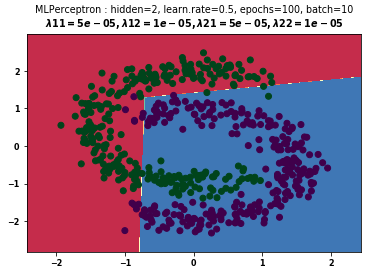


Error rate:  0.0254545454545


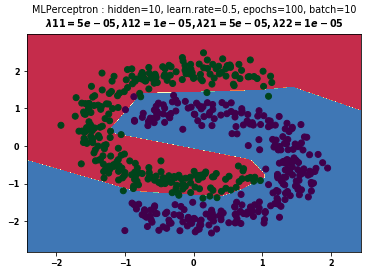


Error rate:  0.00727272727273


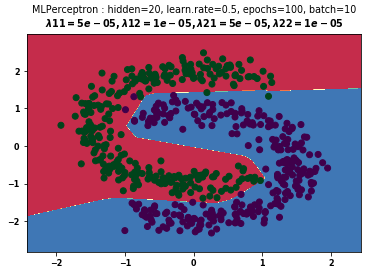


Error rate:  0.0181818181818


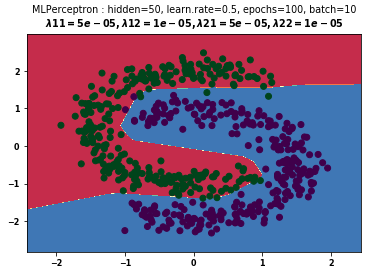

In [250]:
data = np.loadtxt(open('2moons.txt', 'r'))
np.random.shuffle(data)
train_data, test_data = np.vsplit(data, 2)
for nb in [2, 10, 20, 50]:
    perceptron = MLPerceptron(epochs=100, nb_hidden=nb, mu=0.5, batch_size=10, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)
    perceptron.train(train_data)
    prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
    expected = test_data[:, -1].astype(int)  # labels
    print("\nError rate: ", 1 - np.mean(prediction == expected))
    plot_decision_boundary(perceptron, test_data)

Alor, on peut constater qu'en augmentant le nombre de néurones dans la couche cachée, on augmenté la capacité de notre réseau

### Coefficients de régularisation

Cette fois, on va tester les différentes valeurs de coefficients de régularisation 



Error rate:  0.274545454545


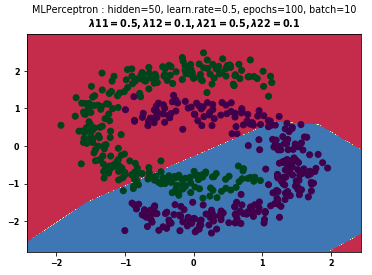


Error rate:  0.223636363636


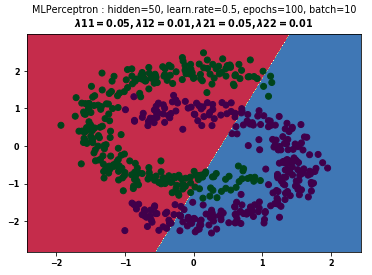


Error rate:  0.0272727272727


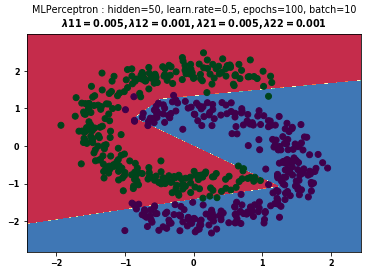


Error rate:  0.0109090909091


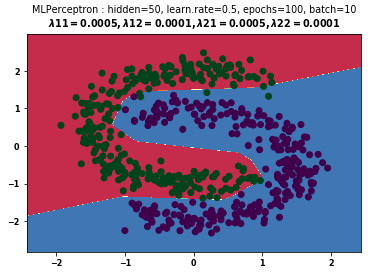


Error rate:  0.00909090909091


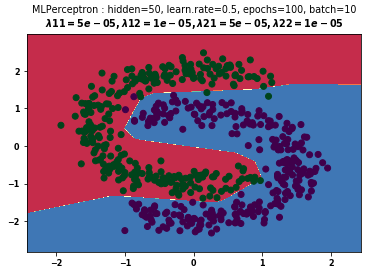


Error rate:  0.0163636363636


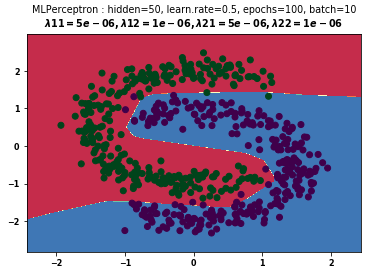


Error rate:  0.0127272727273


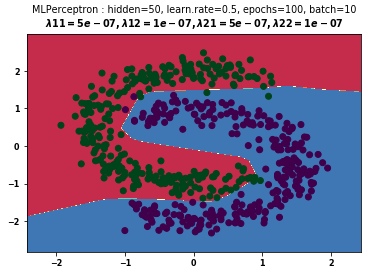

In [254]:
for l11, l12, l21, l22 in [(5e-1, 1e-1, 5e-1, 1e-1),
                           (5e-2, 1e-2, 5e-2, 1e-2),
                           (5e-3, 1e-3, 5e-3, 1e-3),
                           (5e-4, 1e-4, 5e-4, 1e-4),
                           (5e-5, 1e-5, 5e-5, 1e-5),
                           (5e-6, 1e-6, 5e-6, 1e-6),
                           (5e-7, 1e-7, 5e-7, 1e-7)]:
    perceptron = MLPerceptron(epochs=100, nb_hidden=50, mu=0.5, batch_size=10, l11=l11, l12=l12, l21=l21, l22=l22)
    perceptron.train(train_data)
    prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
    expected = test_data[:, -1].astype(int)  # labels
    print("\nError rate: ", 1 - np.mean(prediction == expected))
    plot_decision_boundary(perceptron, test_data)

En effet, très grands coefficients ainsi que les trop pétits diminuent la capacité du réseau. Par contre, une valeur optimale permet de prévenir sur-apprentissage et reduire les erreurs

### Nombre d'itérations (époques)


Error rate:  0.0836363636364


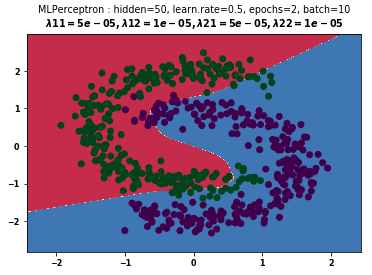


Error rate:  0.0127272727273


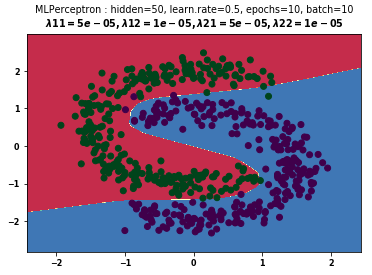


Error rate:  0.0163636363636


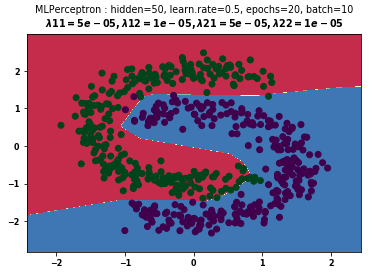


Error rate:  0.0345454545455


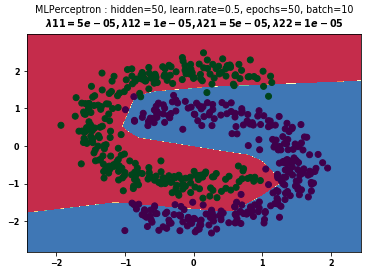


Error rate:  0.0163636363636


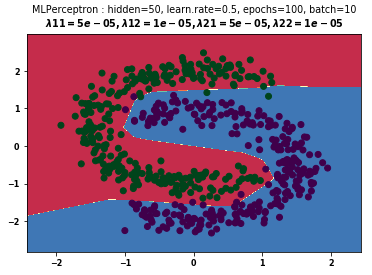

In [256]:
for nb in [2, 10, 20, 50, 100]:
    perceptron = MLPerceptron(epochs=nb, nb_hidden=50, mu=0.5, batch_size=10, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)
    perceptron.train(train_data)
    prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
    expected = test_data[:, -1].astype(int)  # labels
    print("\nError rate: ", 1 - np.mean(prediction == expected))
    plot_decision_boundary(perceptron, test_data)

En général, le processus d'entrainement prend plusiuers itérations (époques). On observe l'amélioration de la capacité et une diminution du taux d'erreurs de notre réseau après plusieurs époques d'entrainement

### Taille de mini-batch


Error rate:  0.0127272727273


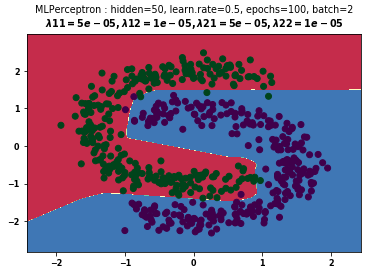


Error rate:  0.00727272727273


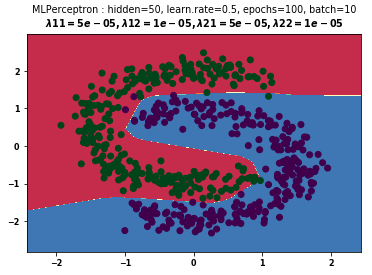


Error rate:  0.00727272727273


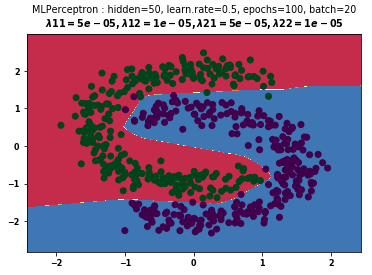


Error rate:  0.00727272727273


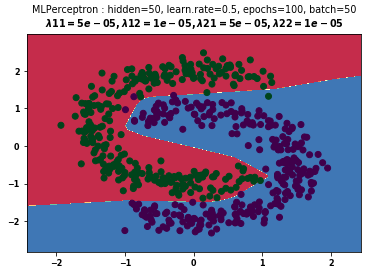


Error rate:  0.0109090909091


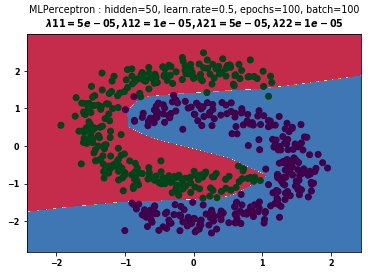

In [258]:
for nb in [2, 10, 20, 50, 100]:
    perceptron = MLPerceptron(epochs=100, nb_hidden=50, mu=0.5, batch_size=nb, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)
    perceptron.train(train_data)
    prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
    expected = test_data[:, -1].astype(int)  # labels
    print("\nError rate: ", 1 - np.mean(prediction == expected))
    plot_decision_boundary(perceptron, test_data)

On voit que la taille optimale de mini-batch pour cette exemple de données est située entre 20 et 50 

### Taux d'apprentissage


Error rate:  0.209090909091


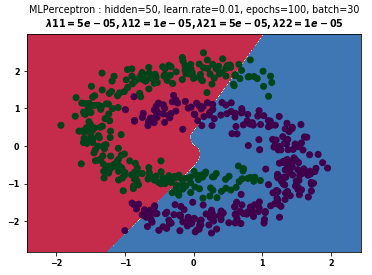


Error rate:  0.0127272727273


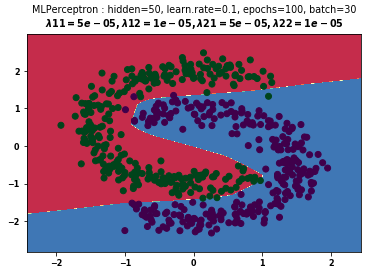


Error rate:  0.00727272727273


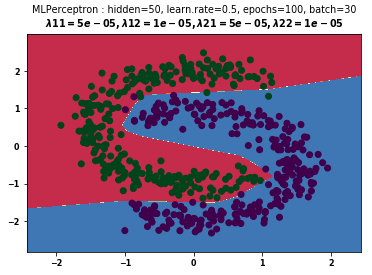


Error rate:  0.0163636363636


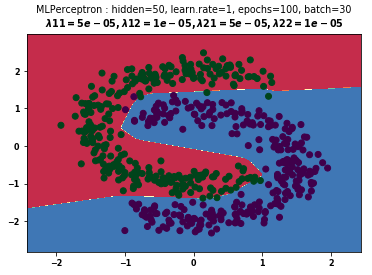


Error rate:  0.507272727273


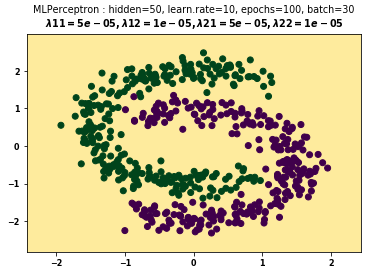

In [261]:
for mu in [0.01, 0.1, 0.5, 1, 10]:
    perceptron = MLPerceptron(epochs=100, nb_hidden=50, mu=mu, batch_size=30, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)
    perceptron.train(train_data)
    prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
    expected = test_data[:, -1].astype(int)  # labels
    print("\nError rate: ", 1 - np.mean(prediction == expected))
    plot_decision_boundary(perceptron, test_data)

On voit, que le choix d'un trop grand taux d'apprentissage a un impact négatif sur ls méthode de descente de gradient,
Le réseau ne se stabilise pas après plusieurs itérations.

## 6. Classifieur utilisant le calcul matriciel

Numpy permet opérations efficaces parallèles sur les matrices,
Alors, leur utilisation dans notre classifieur a grandement augmenté la performance.
### Calcul de prédictions (forward-propagation)

Avant (méthode avec boucle)

In [ ]:
    def fprop(self, x):
        """
        :param x: numpy array of the features, dim = d
        walk forward from input layer x to output layer
        """
        # apply W1 weights + B1 bias
        # ha : array(dh_
        self._ha = np.dot(x, self.w1.transpose()) + self.b1

        # apply non-linear activation function RELU
        # hs : array(dh)
        self._hs = relu(self._ha)

        # apply W2 weights + B2 bias
        # oa : array(m)
        oa = np.dot(self._hs, self.w2.transpose()) + self.b2

        # apply softmax function
        # out : array(m) m = # number of output neurones
        self._out = safe_softmax(oa)


Après (calcul matriciel)

In [262]:
    def fprop(self, x):
        """
        walk forward from input layer x to output layer
        x: matrix (K, d)  K = batch size, d = # neurons in the input layer
        """
        # apply W1 weights + B1 bias
        # ha : matrix (K, dh), dh = # neurons in the hidden layer
        self._ha = np.dot(x, self.w1.transpose()) + self.b1
        
        # apply non-linear activation function RELU
        # hs = matrix (K, dh)
        self._hs = relu(self._ha)
        
        # apply W2 weights + B2 bias
        # oa = matrix (K, m) , m = # neurons in the output layer
        oa = np.dot(self._hs, self.w2.transpose()) + self.b2
        
        # network output
        # apply softmax function
        # out = matrix (K, m) 
        self._out = safe_softmax(oa)  

### Calcul de dérives (back-propagation)

Avant (avec boucle)

In [ ]:

    def bprop(self, x, y):
        """
        Calculate gradients using backpropagation algorithm
        :param x: numpy array of the features, dim = d
        :param y: expected class (scalar)
        :return:
        """
        # calculate gradients
        # start from the output layer
        # grad_oa : array(m), m = # of output neurons
        grad_oa = self._out - one_hot(self.nb_out, y)

        # gradient for W2
        # hs : array(dh), output of the hidden layer
        # grad_w2 : matrix(dh x m)_
        grad_w2 = np.dot(grad_oa.transpose(), self._hs)

        # gradient for B2
        # grad_b2 : array(m)
        grad_b2 = grad_oa

        # gradient for W1
        # grad_hs : array(dh)
        grad_hs = np.dot(grad_oa, self.w2)
        # grad_ha : array(dh)
        grad_ha = np.multiply(grad_hs, relu_derivative(self._ha))
        # grad_w1 : matrix(dh x d)
        grad_w1 = np.dot(grad_ha.transpose(), np.array([x]))
        # grad_b1: array(dh), dh = # of hidden neurons
        grad_b1 = grad_ha
        return grad_w1, grad_b1, grad_w2, grad_b2

Et après

In [263]:
    def bprop(self, x, y):
        """
        Backpropagation algorithm realisation for 2-layer network
        :param x: features, matrix (K, d)
        :param y: numpy array of the expected classes (K)
        :return:
        """
        # calculate gradients
        # start from the output layer
        # matrix grad_oa (K, m) 
        grad_oa = self._out - onehot(self.nb_out, y)
        
        # gradient pour W2 + regularisation (weight decay)
        # hs = matrix(K, dh) out of the hidden layer
        # matrix grad_w2 : (dh x m)
        grad_w2 = np.dot(grad_oa.transpose(), self._hs) / self.batch_size + \
            np.multiply(np.sign(self.w2), self.l21) + \
            np.multiply(self.w2, (self.l22 * 2))
            
        # gradient pour B2
        # grad_b2 : array(m)
        grad_b2 = np.sum(grad_oa, axis=0) / self.batch_size
        
        # gradient pour W1 + regularisation
        # grad_hs : matrix(K, dh)
        grad_hs = np.dot(grad_oa, self.w2)
        # grad_ha : matrix(K, dh)
        grad_ha = np.multiply(grad_hs, relu_derivative(self._ha))
        # grad_w1 : matrix(dh, d)
        grad_w1 = np.dot(grad_ha.transpose(), x) / self.batch_size + \
            np.multiply(np.sign(self.w1), self.l11) +\
            np.multiply(self.w1, (self.l12 * 2))
            
        # gradient pour B1, hidden layer
        # grad_b1 : array(dh)
        grad_b1 = np.sum(grad_ha, axis=0) / self.batch_size
        return grad_w1, grad_b1, grad_w2, grad_b2

### Classifieur utilisant le calcul matriciel

La classe permet aussi de sauvegarder les parametrès calculès dans un fichier ```save_state()``` et les restaurer après avec ```load_state()```. Cela permet d'utiliser cette classe sans avoir l'entrainer chaque fois.

In [9]:
import pickle

class MLPerceptron(object):
    def __init__(self, nb_hidden=6, mu=0.01, epochs=100, batch_size=50,
                 l11=0.005, l12=0.001, l21=0.005, l22=0.001, 
                 grad_threshold=0.02, validate_gradient=False, debug=False):
        self.nb_hidden = nb_hidden
        self.mu = mu
        self.epochs = epochs
        self.grad_threshold = grad_threshold
        self.nb_out = 0
        self.nb_samples = 0
        self.epsilon = 1e-5  # default gradient verification step
        self.train_data = None  # features from training data
        self.w2 = None # weight matrix for output layer (dh, m) 
        self.w1 = None # weight matrix for hidden layer (dh, d) 
        self.b1 = None # bias for hidden layer, array (dh)
        self.b2 = None # bias for output layer, array (m)
        self._ha = None  # hidden layer activations
        self._hs = None  # hidden layer outputs
        self._out = None  # network output layer outputs
        self._validate_gradient = validate_gradient
        self.batch_size = batch_size
        self.l11 = l11
        self.l12 = l12
        self.l21 = l21
        self.l22 = l22
        self.report_file_name = "report.csv"
        self.validation_data = None
        self.test_data = None
        self.debug = debug
        
    def description(self):
        return "{0} : hidden={1}, learn.rate={2}, epochs={3}, batch={4}\n" \
               r"$\lambda11={5}, \lambda12={6}, \lambda21={7}, \lambda22={8}$".format(
            self.__class__.__name__,
            self.nb_hidden,
            self.mu,
            self.epochs,
            self.batch_size,
            self.l11,
            self.l12,
            self.l21,
            self.l22)

    def init_weights(self, i, j):
        """
        Initialize the weight matrix i x j for the layer of n entries
        :param i: number of rows of the matrix W
        :param j: number of columns
        :return: two-dimensional numpy array
        """
        max_val = 1 / np.sqrt(j)
        return np.array([[random_uniform(-max_val, max_val) for _ in range(j)] for _ in range(i)])

    def init_bias(self, i):
        return np.zeros(i)

    def train(self, train_data):
        # initialize the weight matrices and bias arrays
        self.train_data = train_data
        self.nb_samples = np.shape(self.train_data)[0]
        classes = train_data[:, -1].astype(int)  # convert labels to integers
        nb_features = np.shape(train_data)[1] - 1  # exclude the last column which contains the labels
        self.nb_out = np.unique(classes).size  # number neurons in the output layer == number of the classes
        self.w2 = self.init_weights(self.nb_out, self.nb_hidden)  # dimension m X dh
        self.w1 = self.init_weights(self.nb_hidden, nb_features)  # dimensions dh x X
        self.b2 = self.init_bias(self.nb_out)  # dimensions m
        self.b1 = self.init_bias(self.nb_hidden)  # dimension dh
        # train
        report = None
        if self.debug:
            report = open(self.report_file_name, 'wb')
            report.write("epoch,train_error,train_avg_loss,valid_error,valid_avg_loss,test_error,test_avg_loss\n")
        for epoch in range(self.epochs):
            #
            if self.debug:
                self.evaluate_and_log(epoch, report)
            # split the data into mini-batches and train the network for the each batch
            np.random.shuffle(self.train_data)
            for i in range(0, self.nb_samples, self.batch_size):
                batch = self.train_data[i:i + self.batch_size]
                self.train_batch(batch)

        if report is not None:
            report.close()

    def evaluate_and_log(self, epoch, report_file):
        stats = [epoch]
        print("\nEpoch: ", epoch)
        for name, data in [('train', self.train_data), ('validation', self.validation_data), ('test', self.test_data)]:
            if data is not None:
                prediction = self.compute_predictions(data[:, :-1])  # pass only the features without labels
                expected = data[:, -1].astype(int)  # labels
                error = 1 - np.mean(prediction == expected)
                avg_loss = self.average_loss(expected)
                print("%s error rate: " % name, error)
                print("%s average loss: " % name, avg_loss)
                stats.append(error)
                stats.append(avg_loss)
            else:
                stats.append('')
                stats.append('')
        report_file.write(','.join(map(str, stats)) + '\n')

    def load_state(self, params_file):
        f = open(params_file, 'rb')
        state = pickle.load(f)
        for attr in state.items():
            self.__setattr__(attr[0], attr[1])

        print ("\nLoaded classifier configuration ----------------------------")
        print ("W1: ", self.w1)
        print ("b1: ", self.b1)
        print ("W2: ", self.w2)
        print ("b2: ", self.b2)

    def save_state(self, params_file):
        attributes = {k: v for k, v in self.__dict__.items() if not k.startswith('__')}
        print("\nSaving classifier configuration ----------------------------")
        for param in attributes.items():
            print(param)
        f = open(params_file, 'wb')
        pickle.dump(attributes, f)

    def train_batch(self, batch):
        x = batch[:, :-1]
        y = batch[:, -1].astype(int)  # convert labels to integers
        self.fprop(x)
        # Gradient check for each parameter
        backprop_gradient = self.bprop(x, y)
        if self._validate_gradient:
            self.validate_gradient(x, y, backprop_gradient)
        self.update_parameters(*backprop_gradient)

    def validate_gradient(self, x, y, backprop_gradient):
        """
        Validate if the gradient calculated by backpropagation algorithm is similar
        to the empirical gradient calculated with finite step epsilon
        :param x: array of features
        :param y: array of labels
        :param backprop_gradient: gradient calculated by backpropagation algorithm
        :raises: exception if the calculated algorithm is too different from empirical
        """
        # calculate finite gradient
        model_parameters = ['w1', 'b1', 'w2', 'b2']
        for pidx, pname in enumerate(model_parameters):
            # Get the actual parameter value by it's name, e.g. w1, w2 etc
            parameter = self.__getattribute__(pname)
            # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index
                # Save the original value so we can reset it later
                original_value = parameter[ix]
                # Estimate the gradient using (f(x+h) - f(x-h))/2h
                # calculate the empirical error for x+h
                parameter[ix] = original_value + self.epsilon
                self.fprop(x)
                grad_plus = self.empirical_error(y)
                # calculate the empirical error for x-h
                parameter[ix] = original_value - self.epsilon
                self.fprop(x)
                grad_minus = self.empirical_error(y)
                # Reset parameter to original value
                parameter[ix] = original_value

                # verify gradient
                estimated_gradient = (grad_plus - grad_minus) / (2 * self.epsilon)
                calculated_gradient = backprop_gradient[pidx][ix]
                diff = np.abs(calculated_gradient - estimated_gradient)
                summ = np.abs(calculated_gradient) + np.abs(estimated_gradient)
                if summ != 0:
                    grad_error = diff / summ
                    print ("\nGradient error: ", grad_error)
                    if grad_error > self.grad_threshold:
                        print ("\nEstimated gradient: ", estimated_gradient)
                        print ("\nCalculated gradient: ", calculated_gradient)
                        raise Exception("\nGradient diff is too big: ", grad_error)
                it.iternext()

    def empirical_error(self, y):
        """
        Compute regularized empirical error
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        err = np.mean(log_err)
        regularized_err = err + \
            self.l11 * abs(self.w1).sum() + \
            self.l21 * abs(self.w2).sum() + \
            self.l12 * (self.w1 ** 2).sum() + \
            self.l22 * (self.w2 ** 2).sum()
        return regularized_err

    def average_loss(self, y):
        """
        Compute the average loss function
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        return np.mean(log_err)

    def fprop(self, x):
        """
        walk forward from input layer x to output layer
        """
        self._ha = np.dot(x, self.w1.transpose()) + self.b1
        self._hs = relu(self._ha)  # hidden layer output
        oa = np.dot(self._hs, self.w2.transpose()) + self.b2
        self._out = safe_softmax(oa)  # network output

    def bprop(self, x, y):
        """
        Backpropagation algorithm realisation for 2-layer network
        :param x: numpy array of the features
        :param y: numpy array of the expected classes
        :return:
        """
        # calculate gradients
        # start from the output layer
        grad_oa = self._out - onehot(self.nb_out, y)
        # apply regularisation (weight decay)
        grad_w2 = np.dot(grad_oa.transpose(), self._hs) / self.batch_size + \
            np.multiply(np.sign(self.w2), self.l21) + \
            np.multiply(self.w2, (self.l22 * 2))
        grad_b2 = np.sum(grad_oa, axis=0) / self.batch_size
        # then pass to the hidden layer
        grad_hs = np.dot(grad_oa, self.w2)
        grad_ha = np.multiply(grad_hs, relu_derivative(self._ha))
        # apply regularisation (weight decay)
        grad_w1 = np.dot(grad_ha.transpose(), x) / self.batch_size + \
            np.multiply(np.sign(self.w1), self.l11) +\
            np.multiply(self.w1, (self.l12 * 2))
        grad_b1 = np.sum(grad_ha, axis=0) / self.batch_size
        return grad_w1, grad_b1, grad_w2, grad_b2

    def update_parameters(self, grad_w1, grad_b1, grad_w2, grad_b2):
        # update network parameters W1, W2, b1 and b2
        self.w2 -= self.mu * grad_w2
        self.b2 -= self.mu * grad_b2
        self.w1 -= self.mu * grad_w1
        self.b1 -= self.mu * grad_b1

    def compute_predictions(self, test_data):
        # return the most probable class
        self.fprop(test_data)
        return np.argmax(self._out, axis=1)  # we assume that the index == class


## 8. Mesure de performance

On va mesurer le temps d'exécution d'une époque d'entrainement avec deux implememtations différentes de classifieur.
Machine Ubuntu 16.04.3 LTS
Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz, 8 cores
16 GB RAM

#### Calcul avec boucle

In [62]:
import time
import gzip,pickle

f = gzip.open('mnist.pkl.gz')
data = pickle.load(f)

x_train = data[0][0]
y_train = data[0][1]

x_valid = data[1][0]
y_valid = data[1][1]

x_test = data[2][0]
y_test = data[2][1]

train_data = np.append(x_train, y_train[..., None], axis=1)

perceptron = MLPerceptronIterative(epochs=1, nb_hidden=512, mu=0.5, batch_size=50, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)

start = time.time()
perceptron.train(train_data)
stop = time.time()
print("Time: %s" % (stop - start))


Calculated coefficients:

W1: [[-0.03219857 -0.01774108 -0.0094296  ..., -0.00380292 -0.02634371
  -0.02026288]
 [-0.02142829  0.02070883  0.00829431 ..., -0.02130638 -0.02540113
  -0.01462034]
 [ 0.02016922  0.01638168 -0.01069258 ..., -0.03125658 -0.00320782
   0.00455734]
 ..., 
 [ 0.02367121 -0.003585    0.00054038 ..., -0.03238978  0.01328673
   0.02339778]
 [ 0.02760933 -0.02996821 -0.0301123  ..., -0.02901352  0.01687844
  -0.0115141 ]
 [-0.03316131 -0.01774599  0.00665087 ...,  0.00778957 -0.01658238
  -0.01885615]]

b1: [  5.97115304e-02  -4.54385329e-03   6.27380300e-02  -2.10675558e-02
   1.23402945e-02  -8.73327531e-03  -2.20199107e-02  -4.32605799e-03
  -1.90053821e-02   2.53482283e-02  -7.23986379e-02  -2.73248023e-02
   3.13218428e-02   5.70990365e-02  -3.46467779e-02   3.67590457e-02
   6.67758803e-03   6.64269301e-03  -4.21626270e-02   6.76333443e-02
  -5.94955743e-03  -2.33245908e-03  -1.44054357e-02   2.58912737e-02
  -7.46319325e-02   6.61729547e-02  -2.58389493e-0

#### Calcul matriciel numpy

In [11]:
import time
import gzip,pickle

f = gzip.open('mnist.pkl.gz')
data = pickle.load(f)

x_train = data[0][0]
y_train = data[0][1]

x_valid = data[1][0]
y_valid = data[1][1]

x_test = data[2][0]
y_test = data[2][1]

train_data = np.append(x_train, y_train[..., None], axis=1)

perceptron = MLPerceptron(epochs=1, nb_hidden=512, mu=0.5, batch_size=50, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5)

start = time.time()
perceptron.train(train_data)
stop = time.time()
print("Time: %s" % (stop - start))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


Time: 6.61125206947


#### Résultats

Avec boucle: Time: 63.7866799831
Calcul matriciel : Time: 6.61125206947

Alors, on vois que le calcul matriciel est 10 fois plus rapide, que le calcul en utilisant un boucle

## 9 et 10 Mésure de performance et graphique


La fonction qui calcule la perte moyenne:

In [13]:
    def average_loss(self, y):
        """
        Compute the average loss function
        :param y: numpy array of the expected classes
        :return:
        """
        prediction = np.multiply(self._out, onehot(self.nb_out, y))
        precision = np.max(prediction, axis=1)
        log_err = np.multiply(np.log(precision), -1)
        return np.mean(log_err)

La fonction qui collecte les statistiques sur les 3 ensembles de données et les écrit dans un fichier CSV report.csv.
Le fichier a le format suivant:

#### epoch,train_error,train_avg_loss,valid_error,valid_avg_loss,test_error,test_avg_loss

NOTE : le fichier report.csv est attaché au travail

In [ ]:
    def evaluate_and_log(self, epoch, report_file):
        stats = [epoch]
        print "\nEpoch: ", epoch
        for name, data in [('train', self.train_data), ('validation', self.validation_data), ('test', self.test_data)]:
            if data is not None:
                prediction = self.compute_predictions(data[:, :-1])  # pass only the features without labels
                expected = data[:, -1].astype(int)  # labels
                error = 1 - np.mean(prediction == expected)
                avg_loss = self.average_loss(expected)
                print "%s error rate: " % name, error
                print "%s average loss: " % name, avg_loss
                stats.append(error)
                stats.append(avg_loss)
            else:
                stats.append('')
                stats.append('')
        report_file.write(','.join(map(str, stats)) + '\n')

Le procédure du test et la configuration de réseau : hyper-paramèters

In [ ]:
f = gzip.open('mnist.pkl.gz')
data = pickle.load(f)

x_train = data[0][0]
y_train = data[0][1]

x_valid = data[1][0]
y_valid = data[1][1]

x_test = data[2][0]
y_test = data[2][1]

train_data = np.append(x_train, y_train[..., None], axis=1)
validation_data = np.append(x_valid, y_valid[..., None], axis=1)
test_data = np.append(x_test, y_test[..., None], axis=1)

perceptron = MLPerceptron(epochs=100, num_hidden=1500, mu=0.1, batch_size=100, l11=5e-5, l12=1e-5, l21=5e-5, l22=1e-5, debug=True)
perceptron.test_data = test_data
perceptron.validation_data = validation_data

perceptron.train(train_data)

prediction = perceptron.compute_predictions(test_data[:, :-1])  # pass only the features without labels
expected = test_data[:, -1].astype(int)  # labels
print "\nError rate: ", 1 - np.mean(prediction == expected)

### Rapport

<p>Taux d'erreur de classification atteint sur l'ensemble de test : 0.0193
<p>Taux d'erreur de classification atteint sur l'ensemble d'entarinement : 0.0049

In [ ]:
epoch,train_error,train_avg_loss,valid_error,valid_avg_loss,test_error,test_avg_loss
0,0.90618,2.308356727,0.9103,2.30950253038,0.9059,2.3088889935
1,0.08668,0.309079939371,0.0795,0.284226832786,0.0845,0.293287160712
2,0.06754,0.242651019587,0.0638,0.229370507294,0.0661,0.236241192411
3,0.058,0.210154991765,0.0543,0.20119462821,0.0582,0.205407997596
4,0.04924,0.180358034015,0.0456,0.175460679653,0.0513,0.181579327382
5,0.0434,0.162331041314,0.0412,0.159870736624,0.0457,0.164424428379
6,0.04136,0.151278114276,0.0405,0.153251180975,0.0435,0.152790233852
7,0.0366,0.137084879065,0.0365,0.140841243325,0.0397,0.14144892077
8,0.03544,0.134262677148,0.036,0.14015977993,0.0389,0.141512230184
9,0.0324,0.123610634834,0.0314,0.127263143057,0.0354,0.129137824868
10,0.03052,0.118975648632,0.0329,0.124032586452,0.0338,0.125215800551
11,0.02876,0.112492047663,0.0304,0.11934637627,0.0321,0.120089979355
12,0.02764,0.109743537802,0.0292,0.116698155803,0.0321,0.119368765622
13,0.02738,0.109385743777,0.0301,0.119348320019,0.0311,0.117783859763
14,0.02568,0.103673526319,0.0293,0.112513374924,0.0309,0.111899303405
15,0.02466,0.0980628243522,0.0276,0.105946650507,0.0278,0.105108970591
16,0.02328,0.0943714197069,0.0266,0.103841379624,0.028,0.105057554651
17,0.02272,0.0921378165827,0.0264,0.103261558064,0.027,0.104312244914
18,0.0212,0.0862170351945,0.0243,0.0983780761068,0.0256,0.0981724160791
19,0.02034,0.0854133998032,0.025,0.0984024021699,0.0266,0.0990091727455
20,0.02052,0.0844051624076,0.0253,0.0967411963117,0.0257,0.0993545120121
21,0.01922,0.0783198767906,0.0238,0.0928846674257,0.0241,0.0921025020442
22,0.01798,0.0768878751398,0.0227,0.0907116152647,0.0242,0.0907810288689
23,0.01846,0.0751822560639,0.0238,0.0898200374172,0.0247,0.0896503112165
24,0.0177,0.0733293855503,0.0231,0.0891019035995,0.0232,0.0872331103729
25,0.01742,0.0705693083735,0.0223,0.0867732471343,0.0238,0.0863650228127
26,0.01738,0.0704486910487,0.0221,0.0882655612865,0.0239,0.0861506143002
27,0.01634,0.0683752128174,0.0232,0.0850051845658,0.0235,0.0860528134612
28,0.01704,0.0693898919276,0.0231,0.0860250971637,0.0243,0.0873420434212
29,0.01542,0.0640162941959,0.0214,0.0814125540331,0.0226,0.0809974989817
30,0.01498,0.0622719292809,0.0219,0.0810556599839,0.0225,0.0800273623568
31,0.01586,0.064795753335,0.0222,0.0839393265805,0.0233,0.0834497498972
32,0.01496,0.06142383607,0.0226,0.0820644931072,0.0232,0.0800564938274
33,0.01478,0.0601387734419,0.0208,0.0800702132357,0.0223,0.0783901634396
34,0.0159,0.0630639536035,0.0245,0.0837190911464,0.0253,0.0808861610337
35,0.01348,0.0564963014574,0.0193,0.0773654131351,0.0213,0.0754985886539
36,0.01406,0.0575967885698,0.0209,0.0772250447944,0.0223,0.0778343940584
37,0.01294,0.0553232527449,0.0215,0.0790053354722,0.0217,0.0768217018389
38,0.01332,0.0547950939478,0.0205,0.0775256191803,0.0227,0.0773987936425
39,0.01254,0.0537620396354,0.0205,0.0770140439276,0.021,0.0748621510793
40,0.01218,0.052385117646,0.0209,0.0757299488454,0.0211,0.0751414030351
41,0.01252,0.0517245927814,0.0203,0.0763315530716,0.0209,0.0723480414163
42,0.01128,0.0498389421691,0.0201,0.0737366817996,0.0215,0.0734047344328
43,0.01222,0.0507232160306,0.0203,0.0761714553014,0.0223,0.0751105309241
44,0.01106,0.0494379699413,0.0205,0.0748509721874,0.021,0.0731313362737
45,0.01142,0.0480257253757,0.0199,0.0749781911465,0.0218,0.0733365992534
46,0.01106,0.0470614911005,0.0196,0.0730026555487,0.0212,0.0732620126861
47,0.01056,0.0469348103557,0.0205,0.072938169423,0.0199,0.071788845797
48,0.00994,0.0466395674825,0.0206,0.0748963298591,0.0212,0.0715062956475
49,0.00974,0.045079148385,0.0199,0.0723656276725,0.0211,0.070155341606
50,0.01004,0.0443173218657,0.0201,0.0718068385474,0.0206,0.0705091736103
51,0.00958,0.0440713454132,0.0201,0.073690453047,0.0209,0.0713456993345
52,0.0101,0.0431891544836,0.0203,0.0727864483698,0.0205,0.0704724331765
53,0.00956,0.0418673154077,0.0191,0.0715481650979,0.0219,0.0691265139282
54,0.01042,0.043239376392,0.0206,0.0728834830844,0.0213,0.0688613948173
55,0.01018,0.0434234733418,0.0206,0.073550862519,0.0211,0.0700038321171
56,0.01014,0.0437104415819,0.0203,0.0743925576805,0.0216,0.0728264421119
57,0.00956,0.0419181867057,0.0206,0.072137549019,0.0202,0.070299759368
58,0.0091,0.0410096188547,0.0199,0.0727602037305,0.0206,0.0694149459073
59,0.00844,0.0404981345785,0.0195,0.0701664311602,0.0203,0.0689453366283
60,0.0086,0.0391894828006,0.0203,0.0712593384549,0.0198,0.0674745559748
61,0.01008,0.0431894799363,0.022,0.0758880426022,0.0208,0.0728797140047
62,0.00836,0.0395589362387,0.0198,0.0718871164508,0.0206,0.068732236312
63,0.00886,0.0402359650862,0.0198,0.0739367857118,0.0212,0.0696777784896
64,0.00798,0.0371729761193,0.019,0.0691767757872,0.0191,0.0647988066625
65,0.00742,0.0361894993575,0.0187,0.0687955184333,0.0202,0.0656351394901
66,0.00792,0.0375584655771,0.0204,0.0717545490927,0.0199,0.0684413623053
67,0.0071,0.035634658202,0.0187,0.0688702657107,0.0193,0.0639115086027
68,0.00776,0.037336058438,0.0207,0.0712356883117,0.0205,0.0681646924107
69,0.00862,0.038267740181,0.0211,0.0734423572025,0.0213,0.06977696826
70,0.0079,0.0377096197784,0.02,0.0726508239553,0.0205,0.0673385029884
71,0.0079,0.0354031909477,0.0202,0.0694489490044,0.0194,0.0654656647205
72,0.00734,0.0343912621701,0.0193,0.0683566688528,0.0201,0.0656969774291
73,0.00704,0.0344274954344,0.0191,0.0676510935211,0.0199,0.0652311264122
74,0.00648,0.0341032723165,0.0208,0.0697748962604,0.0193,0.0645663785296
75,0.00656,0.0340672443387,0.0186,0.0694903044847,0.02,0.0660437067911
76,0.00588,0.0329230597464,0.0192,0.0694359165664,0.0204,0.0655453334896
77,0.00724,0.0345595393186,0.0201,0.0692334055235,0.0206,0.0667045233412
78,0.00666,0.0333654751102,0.0194,0.068780985889,0.0195,0.0652770653098
79,0.00632,0.0325150078305,0.0198,0.0687449614509,0.021,0.0655354388706
80,0.0066,0.0326038212573,0.0192,0.0698936415216,0.0194,0.0659176028256
81,0.0075,0.0348356799928,0.0205,0.0721723552925,0.0212,0.0674359540374
82,0.00618,0.0313972613255,0.0196,0.0687094898473,0.0197,0.0653204705955
83,0.00656,0.0316584101646,0.0195,0.0694544938633,0.0194,0.064142510573
84,0.00604,0.0323928847464,0.0188,0.070496020839,0.0202,0.0665688394793
85,0.00618,0.031988602056,0.0193,0.069554075482,0.0208,0.0664815572095
86,0.00632,0.0312278940246,0.0192,0.070772714154,0.0197,0.0646525494066
87,0.00612,0.0307664397,0.0195,0.070525769628,0.02,0.0643159320946
88,0.00646,0.0315975905977,0.0199,0.070052228273,0.0193,0.0647244689488
89,0.00524,0.0297266937989,0.019,0.0692447782023,0.0194,0.0635792243686
90,0.0059,0.0311158717334,0.0198,0.071041004087,0.0189,0.0642865131195
91,0.00576,0.0307377994306,0.0195,0.0692232336305,0.0197,0.0646595318989
92,0.00604,0.0305543789051,0.0199,0.0702733626321,0.0192,0.0646169606506
93,0.00502,0.0292067691291,0.0202,0.0694964248264,0.0185,0.0651892510307
94,0.00646,0.0314097449069,0.0204,0.0708897192206,0.0201,0.0663676178316
95,0.00506,0.0285604033323,0.0182,0.0666798826988,0.019,0.0619235205078
96,0.00508,0.0285528702429,0.0188,0.0701623619246,0.0184,0.0632982766536
97,0.00552,0.0287285410428,0.019,0.0680509925036,0.0196,0.0629367147417
98,0.00492,0.0280355093847,0.0187,0.0695746123544,0.0191,0.0631866426556
99,0.0049,0.0274979201885,0.0188,0.0664759800792,0.0193,0.0619272910161


### Graphique

## taux d'erreurs de classification

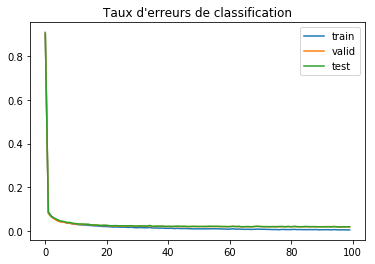

In [16]:
stats = np.loadtxt(open("report_best_rate.csv", "rb"), delimiter=",", skiprows=1)

train = stats[:,1]
valid = stats[:,3]
test = stats[:,5]

plt.plot(train, label='train')
plt.plot(valid, label='valid')
plt.plot(test, label='test')
plt.legend()
plt.title('Taux d\'erreurs de classification')
plt.show()


## perte moyenne

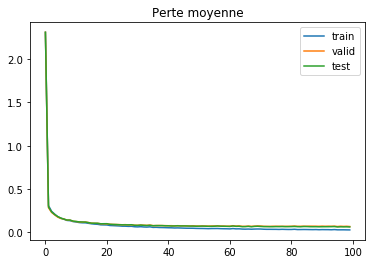

In [18]:
stats = np.loadtxt(open("report_best_rate.csv", "rb"), delimiter=",", skiprows=1)

train = stats[:,2]
valid = stats[:,4]
test = stats[:,6]

plt.plot(train, label='train')
plt.plot(valid, label='valid')
plt.plot(test, label='test')
plt.legend()
plt.title('Perte moyenne')
plt.show()
